In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from series_prediction_helper import TimeSeriesDataset, SeriesPredictionModule, SeriesPredictionDataModule
import glob

xlsx_files = glob.glob(f"./series_prediction_data/*/*.xlsx")

train_files, val_files = train_test_split(xlsx_files, test_size=0.2, shuffle=True, random_state=42)

print(f"Train ({len(train_files)})")
print(f"Test  ({len(val_files)})")

/home/weijiesun/anaconda3/envs/pytorch/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/weijiesun/anaconda3/envs/pytorch/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
2025-07-01 14:34:02.396230: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-01 14:34:02.530382: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libra

Train (116)
Test  (29)


In [2]:
from transformers import AutoformerConfig, AutoformerForPrediction

# device = torch.device('cpu')

prediction_length = 1201
context_length = 300
# lags_sequence = [1, 2, 5, 10, 20, 50, 100]
num_time_features = 0

# # 3. 配置 Autoformer
config = AutoformerConfig(
    prediction_length=prediction_length,  
    context_length=context_length,          

    # multi channel
    input_size=5,                           # 
    scaling=True,                           # 

    lags_sequence=[0],            
    num_time_features=0,

    num_dynamic_real_features=0,
    num_static_categorical_features=0,
    num_static_real_features=0,
    cardinality=[],
    embedding_dimension=[],

    d_model=64,                             
    encoder_layers=3,                       
    decoder_layers=3,                      
    encoder_attention_heads=4,              
    decoder_attention_heads=4,
    encoder_ffn_dim=128,                    
    decoder_ffn_dim=128,
    dropout=0.1,                            
    attention_dropout=0.1,                 
    activation_dropout=0.1,                 # 
    activation_function="gelu",             

    num_parallel_samples=100,
)

In [3]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.strategies import DDPStrategy

# Callbacks
checkpoint_cb = ModelCheckpoint(
    filename='series-{epoch:02d}-{val_nll:.4f}',
    save_top_k=1, monitor='val_loss', mode='min'
)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, mode='min')
devices = [0]
trainer = pl.Trainer(
    max_epochs=5,
    accelerator='cpu',    
    devices=1,           
    precision='32',       
    # accelerator='gpu',
    # devices=devices,  # use GPU 0 and GPU 1
    # strategy=DDPStrategy(find_unused_parameters=True), #allow unused parameters
    # precision='16-mixed',  # updated per Lightning recommendation
    callbacks=[checkpoint_cb, earlystop_cb],
    # logger=wandb_logger
)

# Data & Model instantiation
dm = SeriesPredictionDataModule(train_files, val_files, num_workers = 0)
model = SeriesPredictionModule(config)

# Run training
# trainer.fit(model, dm)


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/weijiesun/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

best_ckpt_path = checkpoint_cb.best_model_path  

import glob
ckpt_files = glob.glob("./lightning_logs/version_*/checkpoints/*.ckpt")

best_ckpt_path = sorted(ckpt_files)[-1]

best_model = SeriesPredictionModule.load_from_checkpoint(
    checkpoint_path=best_ckpt_path,
    config=config
)
val_dataset = TimeSeriesDataset(val_files, input_len=300, output_len=1201)

predictions = trainer.predict(
    best_model,
    dataloaders=DataLoader(
            val_dataset, batch_size=2,
            shuffle=False, num_workers=0
        ),  # 或者直接传 test_dataloader
    ckpt_path=None                     # 因为我们手动 load 了权重
)

all_preds = torch.cat([p['pred_seq'] for p in predictions], dim=0)  # (N, C, pred_len)
all_gts   = torch.cat([p['gt_seq']   for p in predictions], dim=0)  # (N, C, pred_len)

all_preds = all_preds.permute(0, 2, 1)
print(all_preds.shape, all_gts.shape)

/home/weijiesun/anaconda3/envs/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

torch.Size([29, 5, 1201]) torch.Size([29, 1201, 5])


In [10]:
import numpy as np

preds = all_preds.reshape(-1)  # (N*C*T,)
gts   = all_gts.reshape(-1)
preds, gts = preds.numpy(), gts.numpy()

mse  = np.mean((preds - gts)**2)
rmse = np.sqrt(mse)
mae  = np.mean(np.abs(preds - gts))

mask = np.abs(gts) > 1e-6
mape = np.mean(np.abs((preds[mask] - gts[mask]) / gts[mask])) * 100

smape = np.mean(
    2 * np.abs(preds - gts) / (np.abs(preds) + np.abs(gts) + 1e-6)
) * 100

from sklearn.metrics import r2_score
r2 = r2_score(gts, preds)

print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"sMAPE:{smape:.2f}%")
print(f"R2:   {r2:.4f}")


MSE:  852.2455
RMSE: 29.1932
MAE:  11.0615
MAPE: 8.04%
sMAPE:6.84%
R2:   0.9354


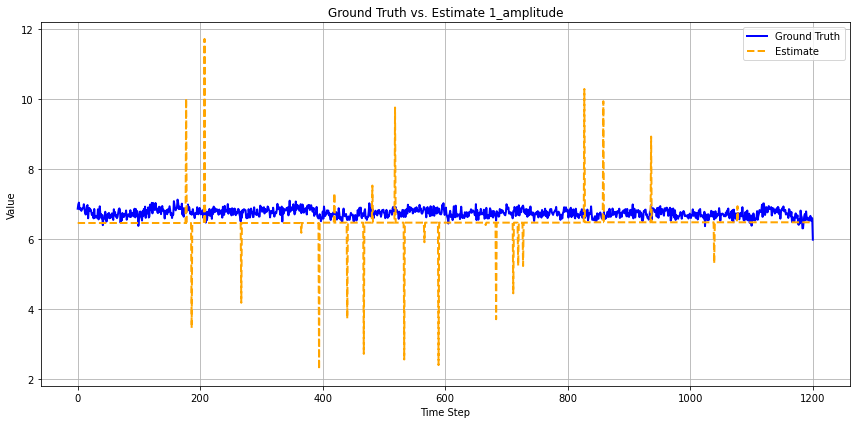

In [27]:
import matplotlib.pyplot as plt
import torch

columns = ['Average_pupil_diameter', '1_direction', 'Average_velocity', 'Peak_velocity', '1_amplitude']
col_index = 4
# 假设 ground_truth 和 estimate 是长度为 115 的 1D 张量
# 示例数据（请替换为你的实际数据）
ground_truth = all_preds[10, :, col_index].cpu()
estimate = all_gts[10, :, col_index].cpu()

# 创建时间步序列
time_steps = list(range(0, len(ground_truth)))  # 从 1 到 115

# 绘制图像
plt.figure(figsize=(12, 6))
plt.plot(time_steps, ground_truth.numpy(), label='Ground Truth', color='blue', linewidth=2)
plt.plot(time_steps, estimate.numpy(), label='Estimate', color='orange', linestyle='--', linewidth=2)

# 添加标题和标签
plt.title(f'Ground Truth vs. Estimate {columns[col_index]}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
